In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import itertools
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
from sklearn.metrics import coverage_error
from sklearn.svm import SVC
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.neural_network import MLPClassifier
import scipy.sparse
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from bs4 import BeautifulSoup

#from sklearn.preprocessing import StandardScaler

from scipy.sparse import coo_matrix, hstack


# Dataset loading

In [3]:
#Dataset loading
dataset2 = pd.read_csv('Cleaned_Posts.csv', nrows = None, index_col=0)
dataset2.shape

(49399, 10)

In [4]:
#Any np.nan ?
dataset2.isnull().sum()

TText             0
TText_NEG         0
PText             0
TCode         10054
PCode          9627
TTitle            0
TTitle_NEG        0
Title             0
PTags             0
Tags              0
dtype: int64

In [5]:
#np.nan cleaning
dataset2['TCode'] = dataset2['TCode'].fillna('None')
dataset2['PCode'] = dataset2['PCode'].fillna('None')

In [6]:
#Any np.nan ?
dataset2.isnull().sum()

TText         0
TText_NEG     0
PText         0
TCode         0
PCode         0
TTitle        0
TTitle_NEG    0
Title         0
PTags         0
Tags          0
dtype: int64

In [7]:
df = pd.DataFrame(dataset2['PTags'].tolist()).stack().value_counts()
#df = df[df>50]
df.shape

(36578,)

In [8]:
existintags = set(df.index)
existintags

{"['c#', 'visual-studio-2017', 'csproj']",
 "['rvm', 'capistrano', 'centos7']",
 "['swift', 'xcode', 'uitableview', 'celltable']",
 "['google-chrome', 'selenium', 'dart', 'basic-authentication']",
 "['arrays', 'angularjs', 'angularjs-ng-repeat']",
 "['indexing', 'excel-formula', 'match', 'aspose', 'aspose-cells']",
 "['java', 'handlebars.js', 'mustache', 'handlebars.java']",
 "['python', 'json', 'python-3.x', 'pandas', 'python-requests']",
 "['json', 'node.js', 'api', 'couchdb', 'cloudant']",
 "['c#', 'c#-7.2']",
 "['python', 'django-rest-framework', 'uwsgi']",
 "['elasticsearch', 'elasticsearch-painless']",
 "['database', 'go', 'google-cloud-datastore']",
 "['regex', 'grammar', 'perl6', 'regex-greedy']",
 "['google-chrome-extension', 'google-chrome-app', 'google-chrome-os']",
 "['mysql', 'distance']",
 "['parallel-processing', 'task-parallel-library', 'mpi', 'openmp']",
 "['r', 'machine-learning', 'random-forest', 'data-science']",
 "['android', 'android-studio', 'gradle', 'kotlin']",

# Dataset splitting

In [43]:
#Downsampling
dataset = dataset2.sample(10000)
dataset.shape

(10000, 10)

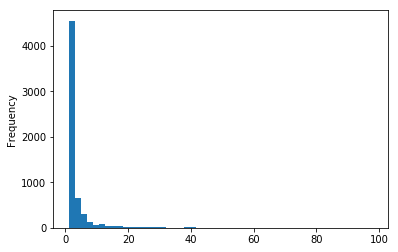

In [44]:
#Most commons tags
dataset['PTags'] = dataset['Tags'].apply(lambda x: [tag.name for tag in BeautifulSoup(x, 'html.parser').find_all()])
df = pd.DataFrame(dataset['PTags'].tolist()).stack().value_counts()
df[df<100].plot(kind = 'hist', bins = 50)
plt.show()

In [45]:
popularitytags = df[df>10].to_dict()
len(popularitytags)

390

In [46]:
#Tags cleaning
textset = dataset.copy()
textset['PTagsCleaned'] = textset['PTags'].apply(lambda x: [tag for tag in x if tag in popularitytags.keys()])
textset['PTagsCleanedLen'] = textset['PTagsCleaned'].apply(lambda x: len(x))
textset = textset[textset['PTagsCleanedLen'] != 0]
textset = textset.dropna()
print(textset.shape)
textset[['PTagsCleaned', 'PTags', 'TCode']].head()

(9094, 12)


,PTagsCleaned,PTags,TCode
Id,,,
48117511,"[java, android, android-studio]","[java, android, android-studio]",private Uri getTempUri () {/ / Create an image...
48078680,[ruby],"[ruby, methods, built-in]","def get_pos func = __method__ . to_s puts "" Yo..."
48072193,"[angular, angular5]","[angular, angular5, ng-modules]",None
48100443,"[excel, excel-formula]","[excel, excel-formula]","= IFERROR ( INDEX ( Sheet1 ! B : B , SMALL ( I..."
48117106,"[javascript, ruby-on-rails, json, reactjs, axios]","[javascript, ruby-on-rails, json, reactjs, axios]",api_key api key data ={ api_key : this . state...


In [47]:
#X set creation
X = textset[['TText', 'TTitle', 'TCode']]

In [48]:
#Label dataset creation

y = textset['PTagsCleaned']

mlb = preprocessing.MultiLabelBinarizer()
Y = mlb.fit_transform(y)
Y.shape

(9094, 390)

In [49]:
#Dataset splitting
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0, shuffle = True)

In [50]:
mlb.classes_

array(['aggregation-framework', 'ajax', 'algorithm', 'amazon-dynamodb',
       'amazon-ec2', 'amazon-s3', 'amazon-web-services', 'anaconda',
       'android', 'android-fragments', 'android-gradle', 'android-layout',
       'android-recyclerview', 'android-room', 'android-studio',
       'android-viewpager', 'angular', 'angular-cli', 'angular5',
       'angularjs', 'animation', 'apache', 'apache-kafka', 'apache-spark',
       'apache-spark-sql', 'api', 'appium', 'arraylist', 'arrays',
       'asp.net', 'asp.net-core', 'asp.net-core-2.0', 'asp.net-core-mvc',
       'asp.net-mvc', 'asp.net-mvc-4', 'asp.net-web-api', 'assembly',
       'asynchronous', 'audio', 'authentication', 'automated-tests',
       'automation', 'aws-lambda', 'axios', 'azure',
       'azure-active-directory', 'bash', 'batch-file', 'bluetooth',
       'boost', 'bootstrap-4', 'button', 'c', 'c#', 'c++', 'c++11',
       'caching', 'canvas', 'cassandra', 'charts', 'checkbox', 'class',
       'cmake', 'codeigniter', 'compu

# LDA version

In [98]:

class CustomLDA(BaseEstimator, TransformerMixin):

    def __init__(self, **params):        
        self.vect_text_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_title_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_code_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        
        self.lda_params = {'n_components':10, 'n_jobs':2, 'random_state':0, 'doc_topic_prior':None, 'topic_word_prior':None}
        
        self.clf_params = {'ntopwords':5, 'ntopics':5}
        
        self.params = {**{'vect_text_'+k:v for k,v in self.vect_text_params.items()},
                       **{'vect_title_'+k:v for k,v in self.vect_title_params.items()},
                       **{'vect_code_'+k:v for k,v in self.vect_code_params.items()},
                       **{'lda_'+k:v for k,v in self.lda_params.items()},
                       **{'clf_'+k:v for k,v in self.clf_params.items()},
                       **params}
        
        self.update_params()

    def predict_word(self, X, y=None):
        self.nametopics()
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()

        toreturn = []
        
        for document in W:
            #select the most important topics
            docprediction = []
            for topic in document.argsort()[:-ntopics-1:-1]:
                tags = [feature_names[i] for i in components[topic].argsort()[:-ntopwords-1:-1]]
                docprediction.extend(tags)
            toreturn.append(docprediction)
        return np.array(toreturn)
    
    def predict(self, X, y=None):
        prediction = self.predict_word(X, y=None)
        self.nametopics()
        toreturn = []
        for keywords in prediction:
            toreturn.append([x for x in keywords if x in self.namedtopics])
        keys = np.array(toreturn)
        return mlb.transform(keys)
        
    
    def fit(self, X, y):
        dftext = X['TText']
        dftitle = X['TTitle']
        dfcode = X['TCode']
        #Text preparation
        self.textcvect = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_text_params)
        text = self.textcvect.fit_transform(dftext)
        
        #Title preparation
        self.titlecvect = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_title_params)
        title = self.titlecvect.fit_transform(dftitle)
        
        #Code preparation
        #self.codecvect = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_code_params)
        #code = self.codecvect.fit_transform(dfcode)
        
        #LDA preparation
        self.lda = LatentDirichletAllocation(learning_method = 'batch', **self.lda_params)
        complete = scipy.sparse.hstack((text, title)) #, code
        self.lda.fit(complete)
        
        self.components_ = self.lda.components_
        
        self.nametopics()
        
        return self
    
    def transformcvect(self, X, y=None):
        dftext = X['TText']
        dftitle = X['TTitle']
        dfcode = X['TCode']
        
        #Text preparation
        textvect = self.textcvect.transform(dftext)
        
        #Title preparation
        titlevect = self.titlecvect.transform(dftitle)
    
        #Code preparation
        #codevect = self.codecvect.transform(dfcode)
        
        return scipy.sparse.hstack((textvect, titlevect)) #, codevect
        
    def transform(self, X, y=None):
        lda = self.lda.transform(self.transformcvect(X))
        return lda
    
    def get_feature_names(self):
        textfnames = self.textcvect.get_feature_names()
        titlefnames = self.titlecvect.get_feature_names()
        #codefnames = self.codecvect.get_feature_names()
        toreturn = []
        toreturn.extend(textfnames)
        toreturn.extend(titlefnames)
        #toreturn.extend(codefnames)
        
        return toreturn
    
 #   def components_(self):        
 #       return self.lda.components_
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.update_params()
        return self
        
    def update_params(self):
        
        self.vect_text_params = {k[10:]:v for k,v in self.params.items() if k.startswith('vect_text_')}
        self.vect_title_params = {k[11:]:v for k,v in self.params.items() if k.startswith('vect_title_')}
        self.vect_code_params = {k[10:]:v for k,v in self.params.items() if k.startswith('vect_code_')}
        
        self.lda_params = {k[4:]:v for k,v in self.params.items() if k.startswith('lda_')}
        
        self.clf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('clf_')}

        return self

    def score(self, X=None, y=None):
        numcomponent = self.lda_params['n_components']
        self.nametopics()
        topicsscore = [1/len(x) if len(x) !=0 else 0 for x in self.topicsnamed.values()]
        return numcomponent * np.array(topicsscore).mean()
    
    def perplexity(self, X, sub_sampling=False):
        return self.lda.perplexity(self.transformcvect(X))
    
    def nametopics(self):
        self.topicsnamed = {}
        self.namedtopics = {}
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        for topicnum, topiccomposition in enumerate(components):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            self.topicsnamed[topicnum] = [tag for tag in tags if tag in popularitytags.keys()]
            for tag in tags:
                if tag in popularitytags.keys():
                    if tag in self.namedtopics.keys():
                        temp = list(self.namedtopics[tag])
                        temp.append(topicnum)
                        self.namedtopics[tag] = set(temp)
                    else:
                        self.namedtopics[tag] = set([topicnum])
        
        return self

    def describe_topics(self, ntopwords=None, ntopics=None):
        if not ntopwords:
            ntopwords = self.clf_params['ntopwords']
        if not ntopics:
            ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        toreturn = []
        
        for topicnum, topiccomposition in enumerate(components[:ntopics]):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            toreturn.append(tags)
        
        return np.array(toreturn)

#customLDA = CustomLDA()


Some docs about the parameters : https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

In [125]:
{'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'lda_doc_topic_prior': 0.008333333333333333,
 'lda_n_components': 100,
 'lda_n_jobs': 2,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.007142857142857143,
 'vect_code_max_df': 0.8,
 'vect_code_max_features': 15000,
 'vect_code_min_df': 10,
 'vect_code_ngram_range': (1, 1),
 'vect_text_max_df': 0.8,
 'vect_text_max_features': 15000,
 'vect_text_min_df': 20,
 'vect_text_ngram_range': (1, 1),
 'vect_title_max_df': 0.7,
 'vect_title_max_features': 5000,
 'vect_title_min_df': 1,
 'vect_title_ngram_range': (1, 1)}

customLDA = CustomLDA(**params)
customLDA.fit(X_train, y_train)

CustomLDA(clf_ntopics=3, clf_ntopwords=5,
     lda_doc_topic_prior=0.008333333333333333, lda_n_components=100,
     lda_n_jobs=2, lda_random_state=0,
     lda_topic_word_prior=0.007142857142857143, vect_code_max_df=0.8,
     vect_code_max_features=15000, vect_code_min_df=10,
     vect_code_ngram_range=(1, 1), vect_text_max_df=0.8,
     vect_text_max_features=15000, vect_text_min_df=20,
     vect_text_ngram_range=(1, 1), vect_title_max_df=0.7,
     vect_title_max_features=5000, vect_title_min_df=1,
     vect_title_ngram_range=(1, 1))

In [126]:
#[1/len(x) if len(x) !=0 else 0 for x in customLDA.topicsnamed.values()]
customLDA.score()

38.5

In [127]:
#Main topics
customLDA.describe_topics(ntopwords=10, ntopics=20)

array([['test', 'use', 'attribut', 'like', 'would', 'someth', 'tri',
        'work', 'ani', 'need'],
       ['java', 'org', 'java', 'com', 'android', 'class', 'method', 'run',
        'invok', 'lang'],
       ['data', 'display', 'code', 'data', 'want', 'use', 'display',
        'help', 'pleas', 'tabl'],
       ['form', 'field', 'templat', 'model', 'product', 'pass', 'django',
        'use', 'like', 'page'],
       ['url', 'com', 'https', 'page', 'use', 'http', 'url', 'domain',
        'redirect', 'www'],
       ['execut', 'plugin', 'task', 'to', 'up', 'progress', 'one', 'use',
        'exampl', 'context'],
       ['script', 'use', 'code', 'script', 'doe', 'tri', 'want', 'run',
        'onli', 'googl'],
       ['map', 'use', 'map', 'tri', 'googl', 'data', 'index', 'inform',
        'get', 'work'],
       ['run', 'chrome', 'work', 'localhost', 'tri', 'use', 'jar', 'issu',
        'ani', 'contain'],
       ['work', 'list', 'use', 'would', 'method', 'question', 'tri', 'get',
        'type'

In [128]:
#Perplexity
customLDA.perplexity(X_test)

4189.3026183872571

In [129]:
customLDA.namedtopics

{'ajax': {71},
 'android': {1, 61, 65},
 'angular': {37},
 'api': {47},
 'button': {87},
 'checkbox': {93},
 'class': {64},
 'csv': {67},
 'date': {14},
 'docker': {27},
 'email': {60},
 'excel': {13},
 'express': {99},
 'file': {11, 59, 67, 77, 78, 85},
 'filter': {93},
 'function': {83},
 'git': {19},
 'graph': {79},
 'html': {37},
 'https': {4},
 'java': {1},
 'javascript': {37},
 'join': {89},
 'json': {63},
 'list': {9},
 'matrix': {31},
 'model': {3, 81},
 'mongodb': {72},
 'npm': {52},
 'object': {63},
 'pdf': {85},
 'php': {57},
 'plot': {14},
 'post': {32, 70},
 'python': {33, 35},
 'random': {40},
 'redirect': {15},
 'search': {48},
 'select': {80},
 'server': {18, 32, 45},
 'session': {15},
 'shell': {44},
 'spring': {51},
 'sql': {45},
 'string': {69},
 'swift': {43},
 'text': {84},
 'time': {26},
 'typescript': {39},
 'url': {4},
 'video': {75},
 'web': {25},
 'webpack': {52},
 'wordpress': {70},
 'xml': {59}}

# TSNE reduction dimension

In [130]:
X_lda = customLDA.transform(X_test)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_lda)

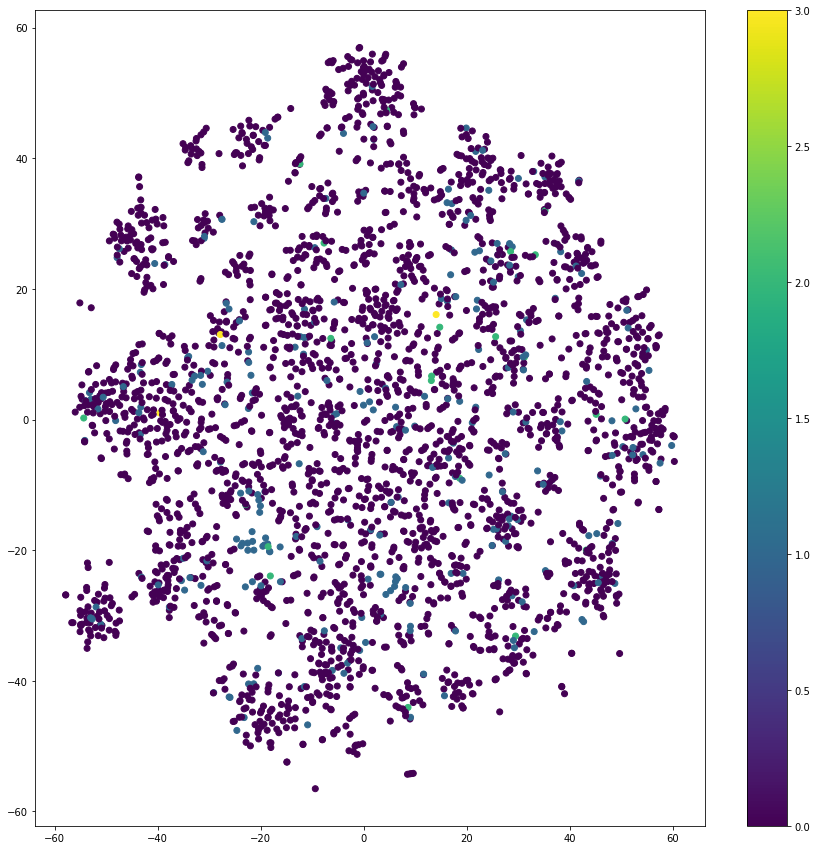

In [131]:
# plot the result
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]
colors = np.argpartition(customLDA.transform(X_test), 0)[:, 0]
plt.figure(figsize=(15, 15))
plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap(), ) 
plt.colorbar()
plt.show()

# GridsearchCV LDA

In [84]:
#Metrics creation

#from sklearn.metrics import fbeta_score
#scorer = make_scorer(fbeta_score, beta=0.5, average = 'micro')
#scorer = make_scorer(jaccard_similarity_score)
scorer = make_scorer(f1_score, average='micro')
#scorer = make_scorer(label_ranking_average_precision_score, needs_proba=False)
#scorer = {'f1':make_scorer(f1_score, average='micro'), 'lra':make_scorer(label_ranking_average_precision_score, needs_proba=True)}


In [114]:
#gridsearch to optimize the parameters - TEXT - STEP 1

topics = 100

params = {'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'lda_n_components': topics,
 'lda_n_jobs': 2,
 'lda_random_state': 0,
 'lda_doc_topic_prior': 1/(topics*1.2),
 'lda_topic_word_prior': 1/(topics*1.4),
 'vect_code_max_df': 0.8,
 'vect_code_max_features': 15000,
 'vect_code_min_df': 10,
 'vect_code_ngram_range': (1, 1),
 'vect_text_max_df': 0.8,
 'vect_text_max_features': 15000,
 'vect_text_min_df': 20,
 'vect_text_ngram_range': (1, 1),
 'vect_title_max_df': 0.7,
 'vect_title_max_features': 5000,
 'vect_title_min_df': 1,
 'vect_title_ngram_range': (1, 1)}

customLDA = CustomLDA(**params)

parameters = {'vect_text_min_df': [20, 10], 'vect_text_max_df': [0.7,0.8,0.9], 'vect_text_max_features': [15000, 10000], 'vect_text_ngram_range': [(1,1)],}
#parameters = {'clf_ntopwords': [5,10], 'lda_doc_topic_prior':[ 1/(topics*1.4), 1/(topics*1.2), 1/(topics), 1/(topics*0.8), 1/(topics*0.6)], 'lda_topic_word_prior':[ 1/(topics*1.4), 1/(topics*1.2), 1/(topics), 1/(topics*0.8), 1/(topics*0.6)]}


clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, scoring = scorer)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] vect_text_max_df=0.8, vect_text_max_features=15000, vect_text_min_df=20, vect_text_ngram_range=(1, 1) 
[CV]  vect_text_max_df=0.8, vect_text_max_features=15000, vect_text_min_df=20, vect_text_ngram_range=(1, 1), score=0.08820179007323027, total=  22.2s
[CV] vect_text_max_df=0.8, vect_text_max_features=15000, vect_text_min_df=20, vect_text_ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.2s remaining:    0.0s


[CV]  vect_text_max_df=0.8, vect_text_max_features=15000, vect_text_min_df=20, vect_text_ngram_range=(1, 1), score=0.09986194201564656, total=  20.7s
[CV] vect_text_max_df=0.8, vect_text_max_features=15000, vect_text_min_df=15, vect_text_ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.7s remaining:    0.0s


[CV]  vect_text_max_df=0.8, vect_text_max_features=15000, vect_text_min_df=15, vect_text_ngram_range=(1, 1), score=0.07246861924686192, total=  21.1s
[CV] vect_text_max_df=0.8, vect_text_max_features=15000, vect_text_min_df=15, vect_text_ngram_range=(1, 1) 
[CV]  vect_text_max_df=0.8, vect_text_max_features=15000, vect_text_min_df=15, vect_text_ngram_range=(1, 1), score=0.09491978609625669, total=  20.7s
[CV] vect_text_max_df=0.8, vect_text_max_features=10000, vect_text_min_df=20, vect_text_ngram_range=(1, 1) 
[CV]  vect_text_max_df=0.8, vect_text_max_features=10000, vect_text_min_df=20, vect_text_ngram_range=(1, 1), score=0.08820179007323027, total=  20.7s
[CV] vect_text_max_df=0.8, vect_text_max_features=10000, vect_text_min_df=20, vect_text_ngram_range=(1, 1) 
[CV]  vect_text_max_df=0.8, vect_text_max_features=10000, vect_text_min_df=20, vect_text_ngram_range=(1, 1), score=0.09986194201564656, total=  20.1s
[CV] vect_text_max_df=0.8, vect_text_max_features=10000, vect_text_min_df=15

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 12.8min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_ntopics=3, clf_ntopwords=5,
     lda_doc_topic_prior=0.008333333333333333, lda_n_components=100,
     lda_n_jobs=2, lda_random_state=0,
     lda_topic_word_prior=0.007142857142857143, vect_code_max_df=0.8,
     vect_code_max_features=15000, vect_code_min_df=10,
     vect_code..._df=0.9,
     vect_title_max_features=5000, vect_title_min_df=1,
     vect_title_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect_text_min_df': [20, 15], 'vect_text_max_df': [0.8, 0.7, 0.6, 0.5], 'vect_text_max_features': [15000, 10000], 'vect_text_ngram_range': [(1, 1)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [115]:
clf.best_params_

{'vect_text_max_df': 0.8,
 'vect_text_max_features': 15000,
 'vect_text_min_df': 20,
 'vect_text_ngram_range': (1, 1)}

In [116]:
clf.best_score_

0.094031866044438431

In [118]:
#Parameters update
params = {**params, **clf.best_params_}
params

{'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'lda_doc_topic_prior': 0.008333333333333333,
 'lda_n_components': 100,
 'lda_n_jobs': 2,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.007142857142857143,
 'vect_code_max_df': 0.8,
 'vect_code_max_features': 15000,
 'vect_code_min_df': 10,
 'vect_code_ngram_range': (1, 1),
 'vect_text_max_df': 0.8,
 'vect_text_max_features': 15000,
 'vect_text_min_df': 20,
 'vect_text_ngram_range': (1, 1),
 'vect_title_max_df': 0.9,
 'vect_title_max_features': 5000,
 'vect_title_min_df': 1,
 'vect_title_ngram_range': (1, 1)}

In [121]:
#gridsearch to optimize the parameters  - TITLE - STEP 2


customLDA = CustomLDA(**params)

parameters = {'vect_title_min_df': [1, 10,20], 'vect_title_max_df': [0.7,0.8,0.9], 'vect_title_max_features': [5000, 7000, 9000], 'vect_title_ngram_range': [(1,1)],}
#parameters = {'lda_doc_topic_prior':[ 1/(topic*1.3), 1/(topic), 1/(topic*0.7)], 'lda_topic_word_prior':[ 1/(topic*1.3), 1/(topic), 1/(topic*0.7)]}


clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, scoring = scorer)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] vect_title_max_df=0.7, vect_title_max_features=5000, vect_title_min_df=1, vect_title_ngram_range=(1, 1) 
[CV]  vect_title_max_df=0.7, vect_title_max_features=5000, vect_title_min_df=1, vect_title_ngram_range=(1, 1), score=0.08820179007323027, total=  21.9s
[CV] vect_title_max_df=0.7, vect_title_max_features=5000, vect_title_min_df=1, vect_title_ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.7s remaining:    0.0s


[CV]  vect_title_max_df=0.7, vect_title_max_features=5000, vect_title_min_df=1, vect_title_ngram_range=(1, 1), score=0.09986194201564656, total=  20.7s
[CV] vect_title_max_df=0.7, vect_title_max_features=5000, vect_title_min_df=10, vect_title_ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.3s remaining:    0.0s


[CV]  vect_title_max_df=0.7, vect_title_max_features=5000, vect_title_min_df=10, vect_title_ngram_range=(1, 1), score=0.08179831408054948, total=  17.5s
[CV] vect_title_max_df=0.7, vect_title_max_features=5000, vect_title_min_df=10, vect_title_ngram_range=(1, 1) 
[CV]  vect_title_max_df=0.7, vect_title_max_features=5000, vect_title_min_df=10, vect_title_ngram_range=(1, 1), score=0.07989756722151088, total=  17.2s
[CV] vect_title_max_df=0.7, vect_title_max_features=5000, vect_title_min_df=20, vect_title_ngram_range=(1, 1) 
[CV]  vect_title_max_df=0.7, vect_title_max_features=5000, vect_title_min_df=20, vect_title_ngram_range=(1, 1), score=0.09202642495006913, total=  18.5s
[CV] vect_title_max_df=0.7, vect_title_max_features=5000, vect_title_min_df=20, vect_title_ngram_range=(1, 1) 
[CV]  vect_title_max_df=0.7, vect_title_max_features=5000, vect_title_min_df=20, vect_title_ngram_range=(1, 1), score=0.08825806451612903, total=  17.2s
[CV] vect_title_max_df=0.7, vect_title_max_features=700

[CV]  vect_title_max_df=0.8, vect_title_max_features=9000, vect_title_min_df=20, vect_title_ngram_range=(1, 1), score=0.09202642495006913, total=  18.2s
[CV] vect_title_max_df=0.8, vect_title_max_features=9000, vect_title_min_df=20, vect_title_ngram_range=(1, 1) 
[CV]  vect_title_max_df=0.8, vect_title_max_features=9000, vect_title_min_df=20, vect_title_ngram_range=(1, 1), score=0.08825806451612903, total=  17.2s
[CV] vect_title_max_df=0.9, vect_title_max_features=5000, vect_title_min_df=1, vect_title_ngram_range=(1, 1) 
[CV]  vect_title_max_df=0.9, vect_title_max_features=5000, vect_title_min_df=1, vect_title_ngram_range=(1, 1), score=0.08820179007323027, total=  22.1s
[CV] vect_title_max_df=0.9, vect_title_max_features=5000, vect_title_min_df=1, vect_title_ngram_range=(1, 1) 
[CV]  vect_title_max_df=0.9, vect_title_max_features=5000, vect_title_min_df=1, vect_title_ngram_range=(1, 1), score=0.09986194201564656, total=  20.7s
[CV] vect_title_max_df=0.9, vect_title_max_features=5000, v

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 19.1min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_ntopics=3, clf_ntopwords=5,
     lda_doc_topic_prior=0.008333333333333333, lda_n_components=100,
     lda_n_jobs=2, lda_random_state=0,
     lda_topic_word_prior=0.007142857142857143, vect_code_max_df=0.8,
     vect_code_max_features=15000, vect_code_min_df=10,
     vect_code..._df=0.9,
     vect_title_max_features=5000, vect_title_min_df=1,
     vect_title_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect_title_min_df': [1, 10, 20], 'vect_title_max_df': [0.7, 0.8, 0.9], 'vect_title_max_features': [5000, 7000, 9000], 'vect_title_ngram_range': [(1, 1)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [122]:
clf.best_params_

{'vect_title_max_df': 0.7,
 'vect_title_max_features': 5000,
 'vect_title_min_df': 1,
 'vect_title_ngram_range': (1, 1)}

In [123]:
clf.best_score_

0.094031866044438431

In [124]:
#Parameters update
params = {**params, **clf.best_params_}
params

{'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'lda_doc_topic_prior': 0.008333333333333333,
 'lda_n_components': 100,
 'lda_n_jobs': 2,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.007142857142857143,
 'vect_code_max_df': 0.8,
 'vect_code_max_features': 15000,
 'vect_code_min_df': 10,
 'vect_code_ngram_range': (1, 1),
 'vect_text_max_df': 0.8,
 'vect_text_max_features': 15000,
 'vect_text_min_df': 20,
 'vect_text_ngram_range': (1, 1),
 'vect_title_max_df': 0.7,
 'vect_title_max_features': 5000,
 'vect_title_min_df': 1,
 'vect_title_ngram_range': (1, 1)}

# Results comparison --> Unsupervised vs Supervised

In [61]:
#Metrics creation

#from sklearn.metrics import fbeta_score
#scorer = make_scorer(fbeta_score, beta=0.5, average = 'micro')
#scorer = make_scorer(jaccard_similarity_score)
#scorer = make_scorer(f1_score, average='micro')
scorer = make_scorer(label_ranking_average_precision_score, needs_proba=False)
#scorer = {'f1':make_scorer(f1_score, average='micro'), 'lra':make_scorer(label_ranking_average_precision_score, needs_proba=True)}


In [62]:
#gridsearch to optimize the parameters - TEXT - STEP 1

{'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'lda_doc_topic_prior': 0.008333333333333333,
 'lda_n_components': 100,
 'lda_n_jobs': 2,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.007142857142857143,
 'vect_code_max_df': 0.8,
 'vect_code_max_features': 15000,
 'vect_code_min_df': 10,
 'vect_code_ngram_range': (1, 1),
 'vect_text_max_df': 0.8,
 'vect_text_max_features': 15000,
 'vect_text_min_df': 20,
 'vect_text_ngram_range': (1, 1),
 'vect_title_max_df': 0.7,
 'vect_title_max_features': 5000,
 'vect_title_min_df': 1,
 'vect_title_ngram_range': (1, 1)}

customLDA = CustomLDA(**params)

#parameters = {'vect_text_min_df': [1, 10], 'vect_text_max_df': [0.9,1.], 'vect_text_max_features': [15000, 20000], 'vect_text_ngram_range': [(1,2), (1,2)],}
parameters = {'clf_ntopwords': [5,10], 'lda_doc_topic_prior':[ 1/(topics*1.4), 1/(topics*1.2), 1/(topics), 1/(topics*0.8), 1/(topics*0.6)], 'lda_topic_word_prior':[ 1/(topics*1.4), 1/(topics*1.2), 1/(topics), 1/(topics*0.8), 1/(topics*0.6)]}


clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=1, scoring=scorer)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] clf_ntopwords=5, lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.0125 
[CV]  clf_ntopwords=5, lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.0125, score=0.027602916252785638, total= 1.1min
[CV] clf_ntopwords=5, lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.0125 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV]  clf_ntopwords=5, lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.0125, score=0.025708874185565743, total= 1.1min
[CV] clf_ntopwords=5, lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.011111111111111112 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s


[CV]  clf_ntopwords=5, lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.011111111111111112, score=0.027460723324972222, total= 1.1min
[CV] clf_ntopwords=5, lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.011111111111111112 
[CV]  clf_ntopwords=5, lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.011111111111111112, score=0.025196642928094808, total= 1.1min
[CV] clf_ntopwords=5, lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125 
[CV]  clf_ntopwords=5, lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125, score=0.026634327771885957, total= 1.1min
[CV] clf_ntopwords=5, lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125 
[CV]  clf_ntopwords=5, lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125, score=0.025019655874876614, total= 1.2min
[CV] clf_ntopwords=5, lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.011111111111111112 
[CV]  clf_ntopwords=5, lda_d

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 32.1min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_ntopics=3, clf_ntopwords=3,
     lda_doc_topic_prior=0.011111111111111112, lda_n_components=100,
     lda_n_jobs=2, lda_random_state=0,
     lda_topic_word_prior=0.011111111111111112, vect_code_max_df=0.8,
     vect_code_max_features=15000, vect_code_min_df=5,
     vect_code_..._df=0.9,
     vect_title_max_features=5000, vect_title_min_df=1,
     vect_title_ngram_range=(1, 2)),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lda_doc_topic_prior': [0.011111111111111112, 0.014285714285714285], 'lda_topic_word_prior': [0.0125, 0.011111111111111112], 'clf_ntopwords': [5, 20, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(label_ranking_average_precision_score),
       verbose=3)

In [38]:
clf.best_score_

0.13767592419464642

In [39]:
clf.best_params_

{'clf_ntopwords': 10,
 'lda_doc_topic_prior': 0.014285714285714285,
 'lda_topic_word_prior': 0.01}

In [132]:
#Direct calculation

{'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'lda_doc_topic_prior': 0.008333333333333333,
 'lda_n_components': 100,
 'lda_n_jobs': 2,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.007142857142857143,
 'vect_code_max_df': 0.8,
 'vect_code_max_features': 15000,
 'vect_code_min_df': 10,
 'vect_code_ngram_range': (1, 1),
 'vect_text_max_df': 0.8,
 'vect_text_max_features': 15000,
 'vect_text_min_df': 20,
 'vect_text_ngram_range': (1, 1),
 'vect_title_max_df': 0.7,
 'vect_title_max_features': 5000,
 'vect_title_min_df': 1,
 'vect_title_ngram_range': (1, 1)}

customLDA = CustomLDA(**params)

#parameters = {'vect_text_min_df': [1, 10], 'vect_text_max_df': [0.9,1.], 'vect_text_max_features': [15000, 20000], 'vect_text_ngram_range': [(1,2), (1,2)],}
#parameters = {'lda_doc_topic_prior':[  1/(topic*0.9), 1/(topic*0.7)], 'lda_topic_word_prior':[ 1/(topic*0.8),  1/(topic*0.9)], 'clf_ntopwords': [5, 20,10],}


#clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=1, scoring=scorer)
customLDA.fit(X_train, y_train)

CustomLDA(clf_ntopics=3, clf_ntopwords=5,
     lda_doc_topic_prior=0.008333333333333333, lda_n_components=100,
     lda_n_jobs=2, lda_random_state=0,
     lda_topic_word_prior=0.007142857142857143, vect_code_max_df=0.8,
     vect_code_max_features=15000, vect_code_min_df=10,
     vect_code_ngram_range=(1, 1), vect_text_max_df=0.8,
     vect_text_max_features=15000, vect_text_min_df=20,
     vect_text_ngram_range=(1, 1), vect_title_max_df=0.7,
     vect_title_max_features=5000, vect_title_min_df=1,
     vect_title_ngram_range=(1, 1))

In [138]:
for tags in customLDA.predict_word(X_test[:10]):
    print(tags)

['error' 'run' 'get' 'tri' 'instal' 'android' 'app' '15' 'use' 'never'
 'servic' 'use' 'servic' 'loop' 'applic']
['run' 'chrome' 'work' 'localhost' 'tri' 'config' 'npm' 'version' 'webpack'
 'run' 'delet' 'git' 'batch' 'repositori' 'push']
['applic' 'studio' 'file' 'visual' 'use' 'url' 'com' 'https' 'page' 'use'
 'run' 'chrome' 'work' 'localhost' 'tri']
['array' 'array' 'like' 'valu' 'element' 'date' 'line' 'plot' 'format'
 'date' 'convert' 'code' 'express' 'use' 'problem']
['work' 'list' 'use' 'would' 'method' 'job' 'day' 'train' 'network' 'model'
 'option' 'swift' 'pick' 'ani' 'merg']
['file' 'file' 'upload' 'csv' 'creat' 'delet' 'git' 'batch' 'repositori'
 'push' 'work' 'list' 'use' 'would' 'method']
['color' 'background' 'use' 'execut' 'start' 'search' 'word' 'document'
 'set' 'use' 'write' 'xml' 'file' 'support' 'use']
['grid' 'socket' 'listen' 'segment' 'event' 'work' 'list' 'use' 'would'
 'method' 'function' 'function' 'call' 'use' 'return']
['bot' 'code' 'set' 'use' 'work' 'copi

In [139]:
mlb.inverse_transform(y_test[:10])

[('android', 'authentication'),
 ('javascript', 'webpack'),
 ('google-chrome',),
 ('ios', 'swift'),
 ('r', 'statistics'),
 ('c#', 'winapi'),
 ('c', 'linux'),
 ('css',),
 ('c#',),
 ('amazon-s3', 'node.js')]

In [153]:
customLDA.predict_word(X_test[:10])

array([['error', 'run', 'get', 'tri', 'instal', 'android', 'app', '15',
        'use', 'never', 'servic', 'use', 'servic', 'loop', 'applic'],
       ['run', 'chrome', 'work', 'localhost', 'tri', 'config', 'npm',
        'version', 'webpack', 'run', 'delet', 'git', 'batch', 'repositori',
        'push'],
       ['applic', 'studio', 'file', 'visual', 'use', 'url', 'com', 'https',
        'page', 'use', 'run', 'chrome', 'work', 'localhost', 'tri'],
       ['array', 'array', 'like', 'valu', 'element', 'date', 'line',
        'plot', 'format', 'date', 'convert', 'code', 'express', 'use',
        'problem'],
       ['work', 'list', 'use', 'would', 'method', 'job', 'day', 'train',
        'network', 'model', 'option', 'swift', 'pick', 'ani', 'merg'],
       ['file', 'file', 'upload', 'csv', 'creat', 'delet', 'git', 'batch',
        'repositori', 'push', 'work', 'list', 'use', 'would', 'method'],
       ['color', 'background', 'use', 'execut', 'start', 'search', 'word',
        'document', 'se

In [140]:
mlb.inverse_transform(customLDA.predict(X_test[:10]))

[('android',),
 ('git', 'npm', 'webpack'),
 ('file', 'https', 'url'),
 ('date', 'express', 'plot'),
 ('list', 'model', 'swift'),
 ('csv', 'file', 'git', 'list'),
 ('file', 'search', 'xml'),
 ('function', 'list'),
 (),
 ('ajax', 'graph', 'post', 'server')]

In [152]:
for index, text in X_test[['TText', 'TTitle']][:10].iterrows():
    print(text['TTitle'])
    #print('\n')
    print(text['TText'])
    print('\n\n')

android spotifi authent doe n't work android 6.0 instal via playstor
'm develop spotify-app android app alreadi run nougat oreo 'm still problem android 6.0 problem instal app via playstor 'm stuck load screen becaus n't receiv correct respons instal exact app android studio work without ani problem also make debug veri difficult becaus ca n't use debugg playstor app ani idea whi got problem devic run android 6.0



make auto reload webpack
webpack.config.j run cmd commnad webpack-dev-serv brows http //localhost:8080/ make ani chang app.j n't see ani reload browser could reload project webpack



headless chrome doe open applic url use robot framework
face issu applic work perfect fine without headless mode open headless mode use chrome capabl someth requir run applic headless mode background 's privat applic doe includ www url



show result decim style exponenti
tri convert valu anoth angstrom arshin russian ancient valu length often got result exponenti style 1.837684e-10 need show 

In [ ]:
article = [48168060, 48150752]
samplepost = dataset[['TText', 'TTitle', 'TCode']].loc[article]
print(dataset["PTags"].loc[article])
np.array(clf.predict(samplepost))

In [ ]:
dataset[['TText', 'TTitle', 'TCode', 'PTags']]

# NMF version

In [ ]:

class CustomNMF(BaseEstimator, TransformerMixin):

    def __init__(self, **params):        
        self.vect_text_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_title_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_code_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        
        self.nmf_params = {'n_components':10, 'random_state':0, 'init':'nndsvd', 'alpha':0, 'l1_ratio':0}
        
        self.clf_params = {'ntopwords':5, 'ntopics':5}
        
        self.params = {**{'vect_text_'+k:v for k,v in self.vect_text_params.items()},
                       **{'vect_title_'+k:v for k,v in self.vect_title_params.items()},
                       **{'vect_code_'+k:v for k,v in self.vect_code_params.items()},
                       **{'nmf_'+k:v for k,v in self.nmf_params.items()},
                       **{'clf_'+k:v for k,v in self.clf_params.items()},
                       **params}
        
        self.update_params()

    def predict(self, X, y=None):
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        W = self.transform(X)
        components = self.components_()
        feature_names = self.get_feature_names()

        toreturn = []
        
        for document in W:
            #select the most important topics
            docprediction = []
            for topic in document.argsort()[:-ntopics-1:-1]:
                tags = [feature_names[i] for i in components[topic].argsort()[:-ntopwords-1:-1]]
                docprediction.append(tags)
            toreturn.append(docprediction)
        return toreturn
    
    def fit(self, X, y=None):
        dftext = X['TText']
        dftitle = X['TTitle']
        dfcode = X['TCode']
        #Text preparation
        self.textcvect = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_text_params)
        text = self.textcvect.fit_transform(dftext)
        
        #Title preparation
        self.titlecvect = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_title_params)
        title = self.titlecvect.fit_transform(dftitle)
        
        #Code preparation
        self.codecvect = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_code_params)
        code = self.codecvect.fit_transform(dfcode)
        
        #LDA preparation
        self.nmf = NMF(**self.nmf_params)
        complete = scipy.sparse.hstack((text, title, code))
        self.nmf.fit(complete)
        
        return self
    
    def transform(self, X, y=None):
        dftext = X['TText']
        dftitle = X['TTitle']
        dfcode = X['TCode']
        
        #Text preparation
        textvect = self.textcvect.transform(dftext)
        
        #Title preparation
        titlevect = self.titlecvect.transform(dftitle)
    
        #Code preparation
        codevect = self.codecvect.transform(dfcode)
        
        nmf = self.nmf.transform(scipy.sparse.hstack((textvect, titlevect, codevect)))
        
        return nmf
    
    def get_feature_names(self):
        textfnames = self.textcvect.get_feature_names()
        titlefnames = self.titlecvect.get_feature_names()
        codefnames = self.codecvect.get_feature_names()
        toreturn = []
        toreturn.extend(textfnames)
        toreturn.extend(titlefnames)
        toreturn.extend(codefnames)
        
        return toreturn
    
    def components_(self):        
        return self.nmf.components_
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.update_params()
        return self
        
    def update_params(self):
        
        self.vect_text_params = {k[10:]:v for k,v in self.params.items() if k.startswith('vect_text_')}
        self.vect_title_params = {k[11:]:v for k,v in self.params.items() if k.startswith('vect_title_')}
        self.vect_code_params = {k[10:]:v for k,v in self.params.items() if k.startswith('vect_code_')}
        
        self.nmf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('nmf_')}
        
        self.clf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('clf_')}

        return self

    def score(self, X=None, y=None):
        numcomponent = self.nmf_params['n_components']
        self.nametopics()
        topicsscore = [1/len(x) if len(x) !=0 else 0 for x in self.topicsnamed.values()]
        return numcomponent * np.array(topicsscore).mean()
    
    def nametopics(self):
        self.topicsnamed = {}
        self.namedtopics = {}
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        components = self.components_()
        feature_names = self.get_feature_names()
        
        for topicnum, topiccomposition in enumerate(components):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            self.topicsnamed[topicnum] = [tag for tag in tags if tag in existintags]
            for tag in tags:
                if tag in existintags:
                    if tag in self.namedtopics.keys():
                        temp = list(self.namedtopics[tag])
                        temp.append(topicnum)
                        self.namedtopics[tag] = set(temp)
                    else:
                        self.namedtopics[tag] = set([topicnum])
        
        return self


customNMF = CustomNMF()


In [ ]:
params = {'clf_ntopics': 3,
 'clf_ntopwords': 3,
 'nmf_n_components': 100,
 'nmf_random_state': 0,
 'vect_code_max_df': 0.8,
 'vect_code_max_features': 15000,
 'vect_code_min_df': 5,
 'vect_code_ngram_range': (1, 2),
 'vect_text_max_df': 0.8,
 'vect_text_max_features': 15000,
 'vect_text_min_df': 10,
 'vect_text_ngram_range': (1, 3),
 'vect_title_max_df': 0.8,
 'vect_title_max_features': 15000,
 'vect_title_min_df': 5,
 'vect_title_ngram_range': (1, 2)}

customNMF = CustomNMF(**params)
customNMF.fit(dataset[['TText', 'TTitle', 'TCode']])

In [ ]:
customNMF.score()
#customNMF.namedtopics

In [ ]:
article = [48168060, 48150752]
samplepost = dataset[['TText', 'TTitle', 'TCode']].loc[article]
print(dataset["PTags"].loc[article])
np.array(customNMF.predict(samplepost))

In [ ]:
customNMF.set_params(clf_ntopwords=5)